# Assignment KNN
Extract features from 300 images from kagel (cat dog panda) 100 images each. and perform 5 fold crossvalidation and plot results with matplot library.

In [80]:
import os
import cv2
import numpy as np
from google.colab import drive
image_dir = "/content/drive/MyDrive/dataset"

In [81]:
image_features = []
image_filenames = []

for filename in os.listdir(image_dir):
    if filename.lower().endswith(".jpg"):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)

        if img is not None:
            hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
            hist = cv2.normalize(hist, hist).flatten()

            image_features.append(hist)
            image_filenames.append(filename)

image_features = np.array(image_features)

In [82]:
category_mapping = {"panda": 2, "cats": 0, "dogs": 1}
image_labels = []

for filename in image_filenames:
    try:
        category = filename.split("_")[0].lower()
        if category in category_mapping:
            image_labels.append(category_mapping[category])
        else:
            print(f"Warning: Unknown category in filename: {filename}")
            image_labels.append(-1)
    except Exception as e:
        print(f"Error processing filename {filename}: {e}")
        image_labels.append(-1)

image_labels = np.array(image_labels)


In [83]:
def create_folds(data, num_folds):
    n_samples = len(data)
    fold_size = n_samples // num_folds
    folds = []
    for i in range(num_folds):
        start_index = i * fold_size
        end_index = start_index + fold_size
        folds.append(data[start_index:end_index])
    return folds

def calculate_distances(test_image, training_set):
    distances = [np.sqrt(np.sum(np.square(test_image - train_image))) for train_image in training_set]
    return distances

def knn(training_set, validation_set, k=5):
    pred_lbls = []
    for test_image in validation_set:
        distances = calculate_distances(test_image, [x[0] for x in training_set])
        nearest_neighbor_indices = np.argsort(distances)[:k]
        neigh_lbl = [training_set[i][1] for i in nearest_neighbor_indices]
        pred_lbl = max(set(neigh_lbl), key=neigh_lbl.count)
        pred_lbls.append(pred_lbl)
    return pred_lbls

all_img_lbls = list(zip(image_features, image_labels))


k_values = list(range(1, 21))
fold_accuracies = {k: [] for k in k_values}

folds_with_labels = create_folds(all_img_lbls, num_folds=5)

for i in range(5):
    print(f"Fold {i+1}:")
    validation_set_with_labels = folds_with_labels[i]
    training_set_with_labels = [
        image_label for j, fold in enumerate(folds_with_labels) if j != i for image_label in fold
    ]

    for k in k_values:
        training_features = [x[0] for x in training_set_with_labels]
        training_labels = [x[1] for x in training_set_with_labels]
        validation_features = [x[0] for x in validation_set_with_labels]
        true_labels = [x[1] for x in validation_set_with_labels]
        pred_lbls = knn(list(zip(training_features, training_labels)), validation_features, k=k)
        correct_pred = sum(1 for predicted, true in zip(pred_lbls, true_labels) if predicted == true)
        accuracy = correct_pred / len(true_labels) if len(true_labels) > 0 else 0
        fold_accuracies[k].append(accuracy)
        print(f"  Accuracy for k={k}: {accuracy:.4f}")
for k, accuracies in fold_accuracies.items():
      average_accuracy = sum(accuracies) / len(accuracies)
      print(f"\nAverage accuracy for k={k} across all folds: {average_accuracy:.4f}")

Fold 1:
  Accuracy for k=1: 0.1667
  Accuracy for k=2: 0.3000
  Accuracy for k=3: 0.2333
  Accuracy for k=4: 0.1667
  Accuracy for k=5: 0.1167
  Accuracy for k=6: 0.1000
  Accuracy for k=7: 0.0667
  Accuracy for k=8: 0.0667
  Accuracy for k=9: 0.0667
  Accuracy for k=10: 0.0333
  Accuracy for k=11: 0.0167
  Accuracy for k=12: 0.0667
  Accuracy for k=13: 0.0667
  Accuracy for k=14: 0.0500
  Accuracy for k=15: 0.0833
  Accuracy for k=16: 0.0333
  Accuracy for k=17: 0.0167
  Accuracy for k=18: 0.0000
  Accuracy for k=19: 0.0000
  Accuracy for k=20: 0.0000
Fold 2:
  Accuracy for k=1: 0.2667
  Accuracy for k=2: 0.4000
  Accuracy for k=3: 0.2667
  Accuracy for k=4: 0.3000
  Accuracy for k=5: 0.3000
  Accuracy for k=6: 0.4000
  Accuracy for k=7: 0.3500
  Accuracy for k=8: 0.4000
  Accuracy for k=9: 0.3167
  Accuracy for k=10: 0.2833
  Accuracy for k=11: 0.3000
  Accuracy for k=12: 0.2833
  Accuracy for k=13: 0.2833
  Accuracy for k=14: 0.2833
  Accuracy for k=15: 0.2833
  Accuracy for k=16: 0

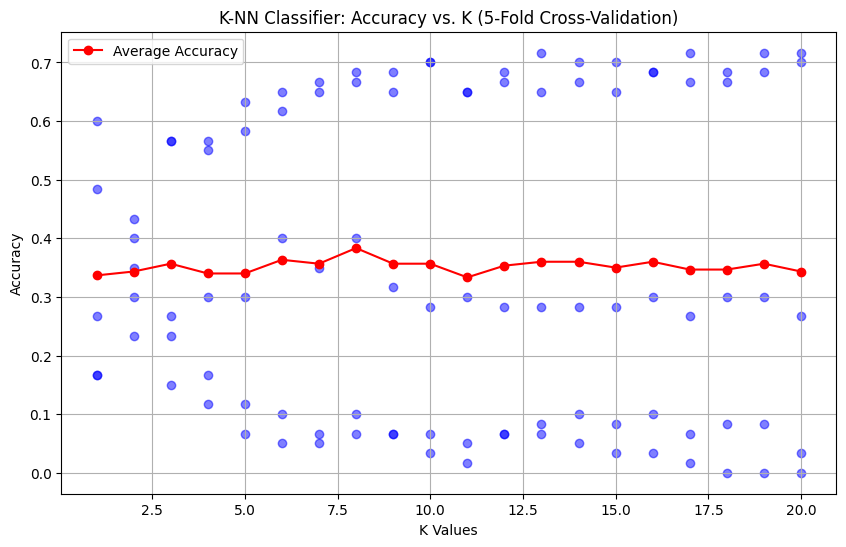

In [84]:
import matplotlib.pyplot as plt
import numpy as np
average_accuracies = {k: sum(accs) / len(accs) for k, accs in fold_accuracies.items()}

plt.figure(figsize=(10, 6))

for k, accs in fold_accuracies.items():
    plt.scatter([k] * len(accs), accs, marker='o', alpha=0.5, color='blue')

plt.plot(list(average_accuracies.keys()), list(average_accuracies.values()), marker='o', label='Average Accuracy', color='red') # Updated label

plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.title('K-NN Classifier: Accuracy vs. K (5-Fold Cross-Validation)')
plt.grid(True)
plt.legend()
plt.show()